# Module 8: LDA with SciKit Learn

* DS 5001
* PUT YOUR NAME HERE

# Set Up

## Configs

In [1]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['book_id', 'chap_num', 'para_num']

import os
#os.chdir('C:\\Users\\dwagn\\Downloads\\Project\\Project')

## Imports

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
%matplotlib inline

# Prepare Data

## Convert TOKENS to table of paragraphs

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.

In [4]:
TOKENS = pd.read_csv('TOKEN2.csv')
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [5]:
PARAS.head()

para_str
book_id chap_num para_num                                                   
121     31       0                                                      note
                 1                                             advertisement
                 2         work year publication bookseller business fart...
        32       1         one infancy born heroine situation character f...
                 2         ten appearances hair balls complexion improved...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [6]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [7]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [8]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [9]:
THETA.sample(20).style.background_gradient()

## PHI

In [10]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [11]:
PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abatement,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
abbey,2.254763,0.033333,0.033333,0.033333,2.368230,3.007307,0.033333,0.033333,0.033333,0.033333,2.215456,1.033333,0.033333,0.033333,3.067315,2.478092,0.614601,0.033333,0.033333,3.250129,1.698437,1.168513,0.033333,3.418664,1.033333,0.984504,0.033333,1.907323,0.033333,0.033333
abbeys,2.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
abhorrence,0.033333,0.033333,0.033333,0.033333,1.480584,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,1.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.586083
abilities,1.033333,0.033333,3.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,0.033333,1.033333,0.033333,1.033333,0.033333,0.033333,0.033333,1.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1.033333,3.033333,0.033333,1.033333,1.033333


# Inspect Results

## Get Top Terms per Topic

In [12]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [13]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,opinion,feelings,time,nature,subject,pleasure,state,mind,heart,cousins
1,time,day,party,pleasure,house,question,family,hour,dinner,morning
2,family,country,character,mind,world,idea,fortune,house,marriage,sister
3,man,choice,comfort,husband,thing,time,daughter,father,gentleman,life
4,man,time,family,sister,feelings,happiness,home,opinion,day,life
5,acquaintance,friends,friend,home,family,pause,wish,kind,opinion,years
6,room,time,countenance,moment,man,mother,letter,day,beauty,way
7,distance,things,room,people,night,thing,miles,world,time,kind
8,time,home,rest,sister,heart,truth,necklace,room,people,sorry


In [14]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

## Sort Topics by Doc Weight

In [15]:
TOPICS['doc_weight_sum'] = THETA.sum()

<AxesSubplot:ylabel='label'>

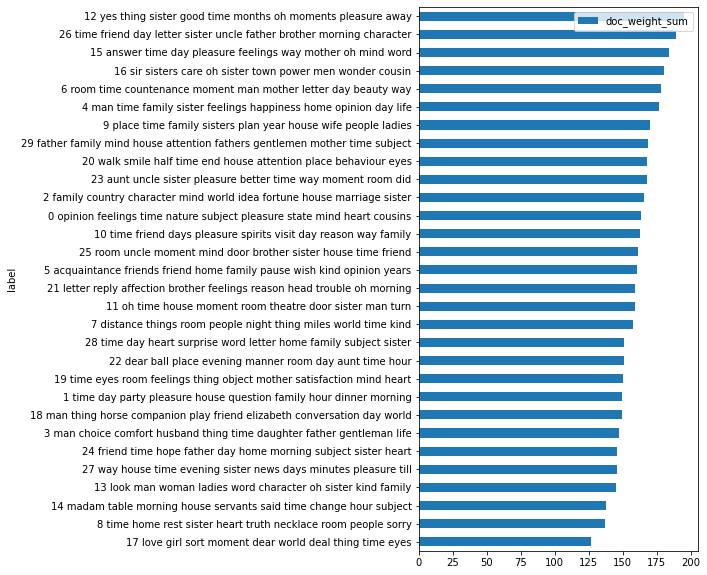

In [16]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

## Explore Topics by book_id

In [17]:
topic_cols = [t for t in range(n_topics)]
BOOK = THETA.groupby('book_id')[topic_cols].mean().T                                            
BOOK.index.name = 'topic_id'

In [18]:
BOOK.T

topic_id,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
book_id,,,,,,,,,,,,,,,,,,,,,
121,0.029482,0.031735,0.027437,0.036432,0.037855,0.034940,0.042745,0.029177,0.023935,0.032359,...,0.037331,0.037809,0.034019,0.035198,0.029901,0.033367,0.034052,0.030226,0.033462,0.033061
141,0.036531,0.029674,0.036215,0.023831,0.043588,0.033593,0.037756,0.035222,0.034135,0.034364,...,0.033845,0.026363,0.029242,0.034580,0.027975,0.038189,0.039120,0.033419,0.035146,0.036637
42671,0.033967,0.032200,0.036638,0.033682,0.030249,0.032681,0.033597,0.032511,0.025709,0.037789,...,0.034878,0.036634,0.032093,0.035015,0.032783,0.029585,0.042321,0.027693,0.027306,0.034854


In [19]:
BOOK['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [20]:
BOOK.sort_values([121, 141, 42671], ascending=False).style.background_gradient()

book_id,121,141,42671,topterms
topic_id,,,,
12,0.045615,0.039860,0.038881,yes thing sister good time months oh moments pleasure away
6,0.042745,0.037756,0.033597,room time countenance moment man mother letter day beauty way
4,0.037855,0.043588,0.030249,man time family sister feelings happiness home opinion day life
21,0.037809,0.026363,0.036634,letter reply affection brother feelings reason head trouble oh morning
20,0.037331,0.033845,0.034878,walk smile half time end house attention place behaviour eyes
3,0.036432,0.023831,0.033682,man choice comfort husband thing time daughter father gentleman life
16,0.035856,0.036437,0.039307,sir sisters care oh sister town power men wonder cousin
15,0.035582,0.035681,0.041902,answer time day pleasure feelings way mother oh mind word
13,0.035332,0.030823,0.027121,look man woman ladies word character oh sister kind family


In [21]:
import plotly_express as px

In [22]:
px.scatter(BOOK.reset_index(), 121, 42671, hover_name='topterms', text='topic_id')\
    .update_traces(mode='text')

# Clutser Topics

In [23]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [24]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [25]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [28]:
labels  = ["{}: {}".format(a,b) for a, b in zip(BOOK.index,  BOOK.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

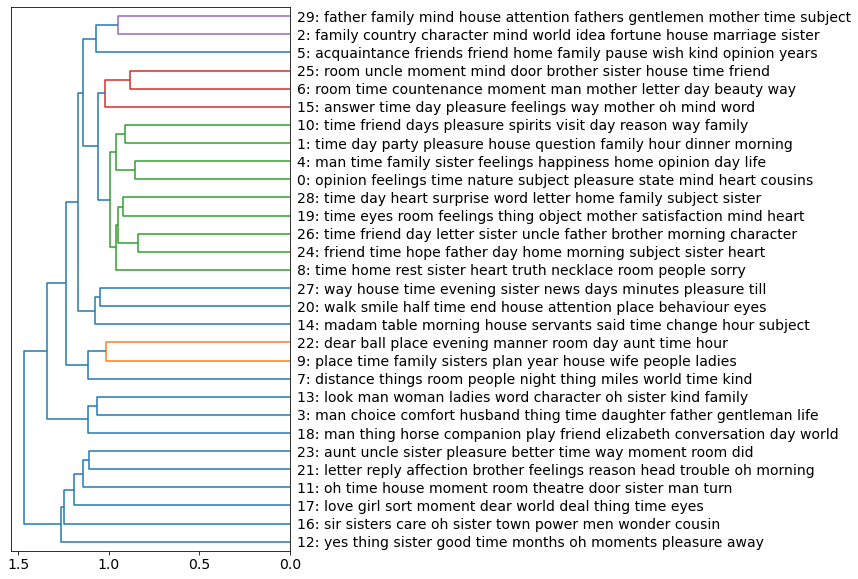

In [29]:
plot_tree(TREE, labels)